# Import Statements

In [ ]:
import pandas as pd # Imported to enable the use of datastructures like dataframe
import numpy as np # Imported for calculations
import tensorflow as tf # Importing tensorflow
from sklearn.model_selection import train_test_split # Imported to enable the user to split the data into train, test samples
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score # Imported to calculate the accuracy and also print the classification report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, TFBertForSequenceClassification, Trainer, TrainingArguments


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


# Importing the dataset

In [ ]:
path='/content/drive/MyDrive/Datasets/malayalam.tsv'
df = pd.read_csv(path, sep='\t')
print(df)

             category                                               text
0      unknown_state    Ichayan fans pinne mmade ettan fansm ivde oru...
1      not-malayalam              Tovi 🥰 Best Wishes From #Kunjikka Fans
2      unknown_state    Urutty koll .nallavanaaya unniyaya saiju kuru...
3      not-malayalam    Pls support me pls       My channel subscribe...
4           Positive      Kalki super hit akum enn Bonny parayan paranju
...               ...                                                ...
6734        Positive      Jayettanu eduthal pongayha role aan...next idi
6735        Positive                 This looks like... Thrishur pooram.
6736        Negative    Mammukka verum vishayam engneru eth enthonn c...
6737  Mixed_feelings    Pulikku pakaram patti odande vere mattam onnu...
6738        Positive    Ithin dislike addikunavar lokka tholvikallayi...

[6739 rows x 2 columns]


In [ ]:
# Renaming the classes

# Removing any leading/trailing spaces
df['category'] = df['category'].str.strip()

# Replacing 'unknown_state' with 'Irrelevant'
df['category'] = df['category'].replace({'unknown_state': 'Neutral'})
df['category'] = df['category'].replace({'not-malayalam': 'Not-Malayalam'})

# Viewing the number of items in each class after replacement
print(df['category'].value_counts())  # Used to view the number of items in each class.

## There is a significant imbalance in the classes in this dataset

Positive          2811
Neutral           1903
Not-Malayalam      884
Negative           738
Mixed_feelings     403
Name: category, dtype: int64


In [ ]:
df['label_num'] = df.category.map({
    'Positive':0,
    'Negative':1,
    'Mixed_feelings':2,
    'Neutral':3,
    'Not-Malayalam':4
})

df.head

<bound method NDFrame.head of             category                                               text  \
0            Neutral   Ichayan fans pinne mmade ettan fansm ivde oru...   
1      Not-Malayalam             Tovi 🥰 Best Wishes From #Kunjikka Fans   
2            Neutral   Urutty koll .nallavanaaya unniyaya saiju kuru...   
3      Not-Malayalam   Pls support me pls       My channel subscribe...   
4           Positive     Kalki super hit akum enn Bonny parayan paranju   
...              ...                                                ...   
6734        Positive     Jayettanu eduthal pongayha role aan...next idi   
6735        Positive                This looks like... Thrishur pooram.   
6736        Negative   Mammukka verum vishayam engneru eth enthonn c...   
6737  Mixed_feelings   Pulikku pakaram patti odande vere mattam onnu...   
6738        Positive   Ithin dislike addikunavar lokka tholvikallayi...   

      label_num  
0             3  
1             4  
2             3

In [ ]:
# Splitting the dataset

# Training Set: 70%
# Test Set: 20%
# Validation Set: 10%

X_train, X_temp, y_train, y_temp = train_test_split(
    df.text,
    df.label_num,
    test_size=.3, # 30% of samples will be present in temporary dataset
    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=1/3, # 10% -> X_val and rest 20% -> X_test
    random_state=42)

print("Training Dataset:" ,X_train.shape[0])
print("Test Dataset:",X_test.shape[0])
print("Validation Dataset:",X_val.shape[0])
# print(X_test,y_test)
# print(X_val,y_val)

Training Dataset: 4717
Test Dataset: 1348
Validation Dataset: 674


In [ ]:
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=5)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(X_train.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(X_val.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')


In [ ]:
k = 0
print('Training Comments -->>',X_train[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',y_train[k])


Training Comments -->>  Ichayan fans pinne mmade ettan fansm ivde oru like idadey Ith nanjankottayile raajavu

Input Ids -->>
 tf.Tensor(
[  101 95502 10335 13113 10790 10136 14023 12668 58341 11064 42493 17996
 37380 55350 64391 13662   119 95502 10335 49119 17629 10592 10948 10206
 13113   119   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0], shape=(84,), dtype=int32)

Decoded Ids -->>
 [CLS] nalla movie aanu ellarum kananam surajettam pwolichu. nalla oru massage thanna movie. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [ ]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [ ]:
# Step 5: Train the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	y_train,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=32,
	epochs=6
)


Epoch 1/6
148/148 [==============================] - 152s 621ms/step - loss: 1.2924 - accuracy: 0.4590 - val_loss: 1.1414 - val_accuracy: 0.5519
Epoch 2/6
148/148 [==============================] - 89s 601ms/step - loss: 0.9361 - accuracy: 0.6517 - val_loss: 0.9360 - val_accuracy: 0.6736
Epoch 3/6
148/148 [==============================] - 89s 601ms/step - loss: 0.7240 - accuracy: 0.7346 - val_loss: 0.9224 - val_accuracy: 0.6677
Epoch 4/6
148/148 [==============================] - 89s 600ms/step - loss: 0.5750 - accuracy: 0.7952 - val_loss: 0.9718 - val_accuracy: 0.6706
Epoch 5/6
148/148 [==============================] - 89s 600ms/step - loss: 0.4299 - accuracy: 0.8495 - val_loss: 1.0476 - val_accuracy: 0.6721
Epoch 6/6
148/148 [==============================] - 89s 600ms/step - loss: 0.3004 - accuracy: 0.9006 - val_loss: 1.0989 - val_accuracy: 0.6543


In [ ]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


43/43 [==============================] - 11s 163ms/step - loss: 1.0851 - accuracy: 0.6639
Test loss: 1.0851174592971802, Test accuracy: 0.6639465689659119


In [ ]:
path = 'path-to-save'
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')


In [ ]:
pred = model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

# Positive':0,
#     'Negative':1,
#     'Mixed_feelings':2,
#     'Neutral':3,
#     'Not-Malayalam':4


label = {
	0: 'Positive',
	1: 'Negative',
  2: 'Mixed_feelings',
  3: 'Neutral',
  4: 'Not-Malayalam'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])


43/43 [==============================] - 10s 164ms/step
Predicted Label : ['Neutral', 'Negative', 'Mixed_feelings', 'Neutral', 'Positive', 'Neutral', 'Mixed_feelings', 'Negative', 'Neutral', 'Neutral']
Actual Label : ['Neutral', 'Negative', 'Not-Malayalam', 'Neutral', 'Positive', 'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral']


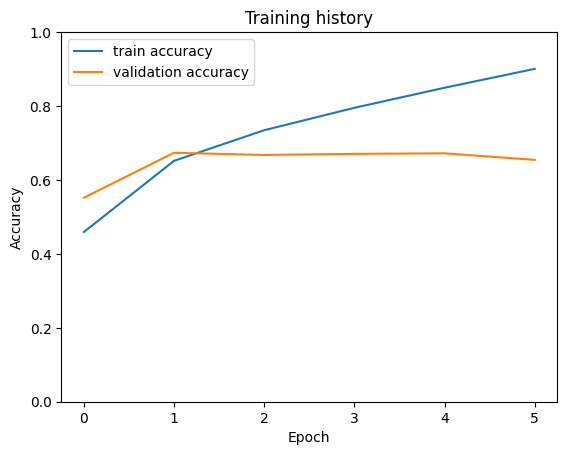

In [ ]:
# Access the history attribute to get the training history
acc = history.history['accuracy']  # Might be 'acc' in some versions of TensorFlow/Keras
val_acc = history.history['val_accuracy']  # Might be 'val_acc' in some versions

# Plot training and validation accuracy
plt.plot(acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

# Graph characteristics
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [ ]:
print("Classification Report: \n", classification_report(Actual, pred_labels))


Classification Report: 
                 precision    recall  f1-score   support

Mixed_feelings       0.35      0.45      0.40        80
      Negative       0.50      0.65      0.57       142
       Neutral       0.61      0.70      0.65       361
 Not-Malayalam       0.72      0.77      0.74       163
      Positive       0.83      0.64      0.73       602

      accuracy                           0.66      1348
     macro avg       0.60      0.64      0.62      1348
  weighted avg       0.69      0.66      0.67      1348



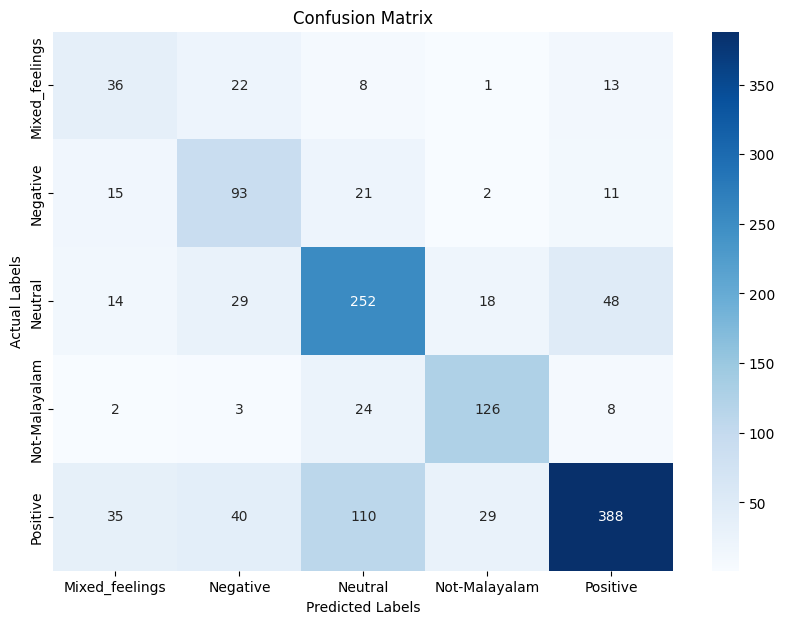

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(Actual, pred_labels)
class_names = np.unique(Actual)  # Assuming y_test contains your actual labels

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()